In [1]:
import numpy as np
import pandas as pd
from numpy import *
from scipy.optimize import *
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# internal functions

In [2]:
# 0. Calcilation of dewpoint temperature, T_dp,C
def T_dp(T, RH):
    T_dp = 257.14*(np.log(RH/100*np.exp((18.678-T/234.5)*(T/(257.14+T)))))/(18.678-(np.log(RH/100*np.exp((18.678-T/234.5)*(T/(257.14+T))))))
    return T_dp

# 1. Calculation of Wetbulb temperature: T_wb, C
# a. first step:
def E_wb(T_wb,P_atm):
    #Satuation pressure of water at wetbulb temperature
    P_sat_twb = 611.2 * np.exp(((18.678 - T_wb/234.5) * T_wb)/(T_wb + 257.14))
    #Absolute humidity at saturation and t_wb
    d_sat_twb = 0.62198 * P_sat_twb/(P_atm - P_sat_twb)
    #Enthalpy at temperature of T_wb
    E_wb = 1.01 * T_wb + (2500 + 1.84 * T_wb) * d_sat_twb
    return E_wb
# b.second step:
def wet_blub(T_oa,RH_oa,P_atm,P_sat):
    #vapor pressure
    P_vapor = P_sat * RH_oa/100
    #absolute humidity
    d_oa = 0.62198 * P_vapor/(P_atm - P_vapor)
    #Enthalpy at temperature of T_oa
    E_oa = 1.01 * T_oa + (2500 + 1.84 * T_oa) * d_oa
    y = lambda t: E_wb(t,P_atm) - E_oa
    initial_guess = -20
    T_wb = fsolve(y,initial_guess)[0]
    return T_wb

# 2.
# 3. 
# 4.
# 5.
# 6.
# 7.

# 8. Air density, kg/m^3
def air_density(P_atm,T_air):
    density = 1.293*(P_atm/101325)*(273.15/(273.15+T_air))
    return density

# 9. Fan power, kW
def Fan_Power(mass_flow_rate,air_density,Fan_Pressure,Fan_e):
    power = mass_flow_rate/air_density*Fan_Pressure/Fan_e/1000
    return power

# 10. Pump power, kW
def Pump_Power(mass_flow_rate,Pump_Pressure,Pump_e,liquid_density):
    power = Pump_Pressure*mass_flow_rate/(1000*Pump_e*liquid_density)
    return power

# 11. Latent heat of vaporization of water: H_water, kj/kg
def Latent_heat_vaporization(T_water):
    H_water = -0.0013*(T_water)**(2)-2.3097*(T_water)+2500.5
    return H_water

# 12. In waterside economizer, the calculation of supply facility water temperature: T_sfw, (chiller system can also use this one if want)
def T_supplywater(T_sa,T_ra,HTE):
    T_sfw = T_ra - (T_ra - T_sa)/HTE
    return T_sfw

# 13. Usage scenario of waterside economizer: 1--use, 0--not use
def Waterside_economizer_use(T_rfw,T_wb_oa,AT_CT,AT_HE):
    if T_wb_oa + AT_CT + AT_HE <= T_rfw:
        use = 1
    else:
        use = 0
    return use

# 14. The heat removed by waterside economizer: WE_heat_removed, kW
def Water_heat_removed(Cooling_required,T_sfw,T_rfw,T_wb_oa,AT_CT,AT_HE):
    if (T_wb_oa + AT_CT + AT_HE) <= T_sfw:
        WE_heat_removed = Cooling_required
    elif (T_wb_oa + AT_CT + AT_HE) > T_sfw and (T_wb_oa + AT_CT + AT_HE) < T_rfw:
        WE_heat_removed = Cooling_required*((T_rfw-(T_wb_oa + AT_CT + AT_HE))/(T_rfw-T_sfw))
    else:
        WE_heat_removed = 0
    return WE_heat_removed

# 15.

# 16. Air or liquid cooling requirements
def Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage):
    Powerloss_UPS = Power_IT/UPS_e - Power_IT
    Powerloss_PD = Power_IT/(1-PD_lr) - Power_IT
    Power_Lighting = Power_IT * L_percentage
    Heat_people = 0
    # Total heat generaton of data center:
    DC_heat = Power_IT + Powerloss_UPS + Powerloss_PD + Power_Lighting + Heat_people
    # Cooling supplied by air: DC_heat_AC, kW (use air to cool IT devices)
    DC_heat_AC = DC_heat * AC_percentage
    # Cooling supplied by air: DC_heat_LC, kW (use liquid to cool IT devices)
    DC_heat_LC = DC_heat * LC_percentage
    return Powerloss_UPS,Powerloss_PD,Power_Lighting,Heat_people,DC_heat_AC,DC_heat_LC,DC_heat

# COP of Chiller, kW/kW (regression)
def COP_Chiller(load, t):
    COP = 16.798751 +  0.008840*t**2 - 8.528931*load**2 + 9.885294*load - 0.760621*t + 0.084615*load*t
    return COP

# Power used by IT equipments:
Power_IT = 1
# Percentage of air cooling:
AC_percentage = 100/100
# Percentage of liquid cooling:
LC_percentage = 1 - AC_percentage

In [3]:
def PUE_WUE_WE_Chiller(w_wech):
    T_oa = w_wech[0]
    RH_oa = w_wech[1]
    P_atm = w_wech[2]
    
    UPS_e = w_wech[3]
    PD_lr = w_wech[4]
    L_percentage = w_wech[5]
    
    T_sa_setpoint = w_wech[6]
    
    delta_T_air = w_wech[7]
    delta_T_water = w_wech[8]
    delta_T_CT = w_wech[9]
    
    Fan_Pressure_CRAC = w_wech[10]
    Fan_e_CRAC = w_wech[11]
    Fan_Pressure_CT = w_wech[12]
    Fan_e_CT = w_wech[13]
    
    Pump_Pressure_HD = w_wech[14]
    Pump_e_HD = w_wech[15]
    Pump_Pressure_WE = w_wech[16]
    Pump_e_WE = w_wech[17]
    Pump_Pressure_CW = w_wech[18]
    Pump_e_CW = w_wech[19]
    Pump_Pressure_CT = w_wech[20]
    Pump_e_CT = w_wech[21]

    AT_CT = w_wech[22]
    AT_HE = w_wech[23]
    HTE = w_wech[24]
    SHR = w_wech[25]
    Chiller_load = w_wech[26]
    pCOP = w_wech[27]
    L_to_G = w_wech[28]
    
    #Dewpoint: dp_oa, C
    dp_oa = T_dp(T_oa, RH_oa)
    #Saturation vapor pressure: P_sat, Pa
    P_sat = 611.21 * np.exp(((18.678 - T_oa/234.5) * T_oa)/(T_oa + 257.14))
    #Vapor pressure: P_vapor, Pa
    P_vapor = P_sat * RH_oa/100
    #Absolute humidity: d_oa, g/kg
    d_oa = 622 * (RH_oa/100 * P_sat)/(P_atm - RH_oa/100 * P_sat)
    #Wetbulb temperature of outdoor air: T_wb_oa, C
    T_wb_oa = wet_blub(T_oa,RH_oa,P_atm,P_sat)
    #Air density: ad_oa, kg/m^3:
    density_oa = air_density(P_atm,T_oa)
    #Air enthalpy: E_oa, kJ/kg
    E_oa = 1.01 * T_oa + (2500 + 1.84 * T_oa) * d_oa/1000
    
    #Cooling requirements: kW
    DC_heat_AC = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[4]
    #CRAC supply air drybulb temperature: T_sa, C
    T_sa = T_sa_setpoint
    #CRAC return air drybulb temperature: T_sa, C
    T_ra = T_sa + delta_T_air
    #Density of supply air: density_sa, kg/m^3
    density_sa = air_density(P_atm,T_sa)
    # Mass flow rate of supply air: m_sa, kg/s
    m_sa = DC_heat_AC/(1.01 * delta_T_air )
    ###(1.Power)###: CRAC Fan power use: Power_Fan_CRAC, kW
    Power_Fan_CRAC = Fan_Power(m_sa,density_sa,Fan_Pressure_CRAC,Fan_e_CRAC)
    #Latent heat removed by air, DC_heat_latent, kW
    DC_heat_latent = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[6]/SHR - DC_heat_AC
    #Cooling required: Cooling_required, kW
    Cooling_required = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[6] + DC_heat_latent
    #Supply facility water temperature: T_sfw, C
    T_sfw = T_supplywater(T_sa,T_ra,HTE)
    #Return facility water temperature: T_rfw, C
    T_rfw = T_sfw + delta_T_water
    #Estimated temperature of condensate water: T_cw, C
    T_cw = (T_sfw + T_rfw)/2
    #Humidification amount, kg/s
    hd_amount = DC_heat_latent/Latent_heat_vaporization(T_cw)
    ###(2.Power)###: Power used by humidification pump, kW
    Power_Pump_hd = Pump_Power(hd_amount,Pump_Pressure_HD,Pump_e_HD,1000)  
    #Usage scenario of waterside economizer: 1--use, 0--not use
    WE_use = Waterside_economizer_use(T_rfw,T_wb_oa,AT_CT,AT_HE)
    #The heat removed by waterside economizer: WE_heat_removed, kW
    WE_heat_removed = Water_heat_removed(Cooling_required,T_sfw,T_rfw,T_wb_oa,AT_CT,AT_HE)
    #Mass flow rate of facility water: m_sfw = m_rfw, kg/s
    m_sfw = WE_heat_removed/(4.2*delta_T_water)
    ###(3.Power)###: Power used by waterside economizer pump: Power_Pump_WE, kW
    Power_Pump_WE = Pump_Power(m_sfw,Pump_Pressure_WE,Pump_e_WE,1000)
    #Additional cooling needed, if the case, kW
    Chiller_heat_removed = Cooling_required - WE_heat_removed
    #COP of chiller: COP_chiller, kW/kW (regression Mean*(1+%COP))
    COP_chiller = COP_Chiller(Chiller_load,T_wb_oa+AT_CT)*(1+pCOP)
    ###(4.Power)###: Power used by Chiller: Power_Chiller, kW
    Power_Chiller = Chiller_heat_removed/COP_chiller
    #Mass flow rate of chiller water: m_sw = m_rw, kg/s
    m_sw = Chiller_heat_removed/(4.2*(delta_T_water))
    ###(5.Power)###: Power used by chilled water pump: Power_Pump_CW, kW
    Power_Pump_CW = Pump_Power(m_sw,Pump_Pressure_CW,Pump_e_CW,1000)
    #Heat removed by cooing tower: CT_heat_removed, kW
    CT_heat_removed = Cooling_required + Power_Chiller
    #Mass flow rate of cooling tower water: m_CT, kg/s
    m_CT = CT_heat_removed/(4.2*delta_T_CT)
    ###(6.Power)###: Power used by cooling tower water pump: Power_Pump_CT, kW
    Power_Pump_CT = Pump_Power(m_CT,Pump_Pressure_CT,Pump_e_CT,1000)
    ###(7.Power)###: Power used by cooling tower fan: Power_Fan_CT, kW
    Power_Fan_CT = Fan_Power(m_CT/L_to_G,density_oa,Fan_Pressure_CT,Fan_e_CT)
    
    ###(0.Power)###: UPS
    Powerloss_UPS = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[0]
    ###(0.Power)###: PD
    Powerloss_PD = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[1]
    ###(0.Power)###: Lighting
    Power_Lighting = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[2]
    
    PUE_WE_CH = (Power_IT + Powerloss_UPS + Powerloss_PD + Power_Lighting + Power_Fan_CRAC + Power_Pump_hd + Power_Pump_WE + Power_Chiller + Power_Pump_CW + Power_Pump_CT + Power_Fan_CT)/Power_IT
    return PUE_WE_CH

In [4]:
# Define the model inputs
problem_WE_Chiller = {
    'num_vars': 29,
    'names': ['T_oa','RH_oa','P_atm','UPS_e','PD_lr','L_percentage','T_sa_setpoint',
              'delta_T_air','delta_T_water','delta_T_CT','Fan_Pressure_CRAC','Fan_e_CRAC',
              'Fan_Pressure_CT','Fan_e_CT','Pump_Pressure_HD','Pump_e_HD','Pump_Pressure_WE',
              'Pump_e_WE','Pump_Pressure_CW','Pump_e_CW','Pump_Pressure_CT',
              'Pump_e_CT','AT_CT','AT_HE','HTE','SHR','Chiller_load','pCOP','L_to_G'],
    'bounds': [[-10, 40], #T_oa
               [0, 100], #RH_oa
               [101325*0.9,101325*1.1], #P_atm
               [90/100, 99/100], #UPS_e
               [0/100, 2/100], #PD_lr
               [0/100, 0.2/100], #L_percentage
               [27,35],#T_sa_setpoint
               [25*5/9, 35*5/9], #delta_T_air
               [5, 10], #delta_T_water
               [4, 6], #delta_T_CT
               [400, 600], #Fan_Pressure_CRAC
               [0.65, 0.90], #Fan_e_CRAC
               [100,400], #Fan_Pressure_CT
               [0.65, 0.90], #Fan_e_CT
               [7000000*0.9, 7000000*1.1], #Pump_Pressure_HD
               [0.6, 0.8], #Pump_e_HD
               [143658*0.8,143658*1.2], #Pump_Pressure_WE
               [0.6, 0.8], #Pump_e_WE
               [143658*0.8,143658*1.2], #Pump_Pressure_CW
               [0.6, 0.8], #Pump_e_CW
               [208660*0.8,208660*1.2], #Pump_Pressure_CT 
               [0.6,0.8], #Pump_e_CT
               [2.8,6.7], #AT_CT
               [1.7,2.8], #AT_HE
               [0.7,0.9], #HTE
               [0.95,0.99], #SHR
               [0.2,0.8], #Chiller_load
               [-11/100,11/100], #pCOP
               [1,3], #L_to_G
                ],            
    
    'dists': ['unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif']
}

In [5]:
# Generate samples
sample_size = 10000

sobol_values = saltelli.sample(problem_WE_Chiller, sample_size)

Y_sobol = np.zeros([sobol_values.shape[0]])

for i, X in enumerate(sobol_values):
    Y_sobol[i] = PUE_WUE_WE_Chiller(X)

C:\Users\nuoal\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [6]:
# Perform analysis
Si = sobol.analyze(problem_WE_Chiller, Y_sobol,num_resamples=100,print_to_console=False)

In [7]:
inx = np.where([Si['ST'] > 0.01])[1]
flabel = []

for i in inx:
    flabel.append(problem_WE_Chiller['names'][i])

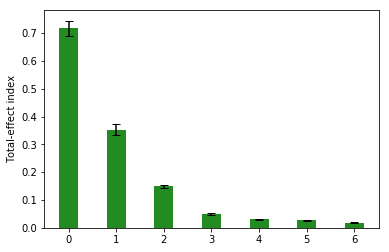

In [8]:
list = Si['ST'][Si['ST'] > 0.01]
index=np.argsort(list)[::-1]

list_cf = Si['ST_conf'][Si['ST'] > 0.01]

plt.bar(range(len(list)),list[index],width=0.4,yerr=list_cf[index],align='center',capsize=4,color='forestgreen')
plt.ylabel("Total-effect index")

plt.show()

In [9]:
print(flabel)
print(list)

['T_oa', 'RH_oa', 'UPS_e', 'T_sa_setpoint', 'AT_CT', 'HTE', 'Chiller_load']
[0.71683393 0.35268348 0.14969271 0.04848402 0.01897741 0.02628769
 0.03040805]


In [10]:
label = ['Outdoor air\ndry bulb temperature','Outdoor air\nrelative humidity','UPS efficiency','Supply air dry bulb\ntemperature set point','Chiller load','CRAC cooling coils (heat\nexchanger effectiveness)','Cooling tower\napproach temperature']

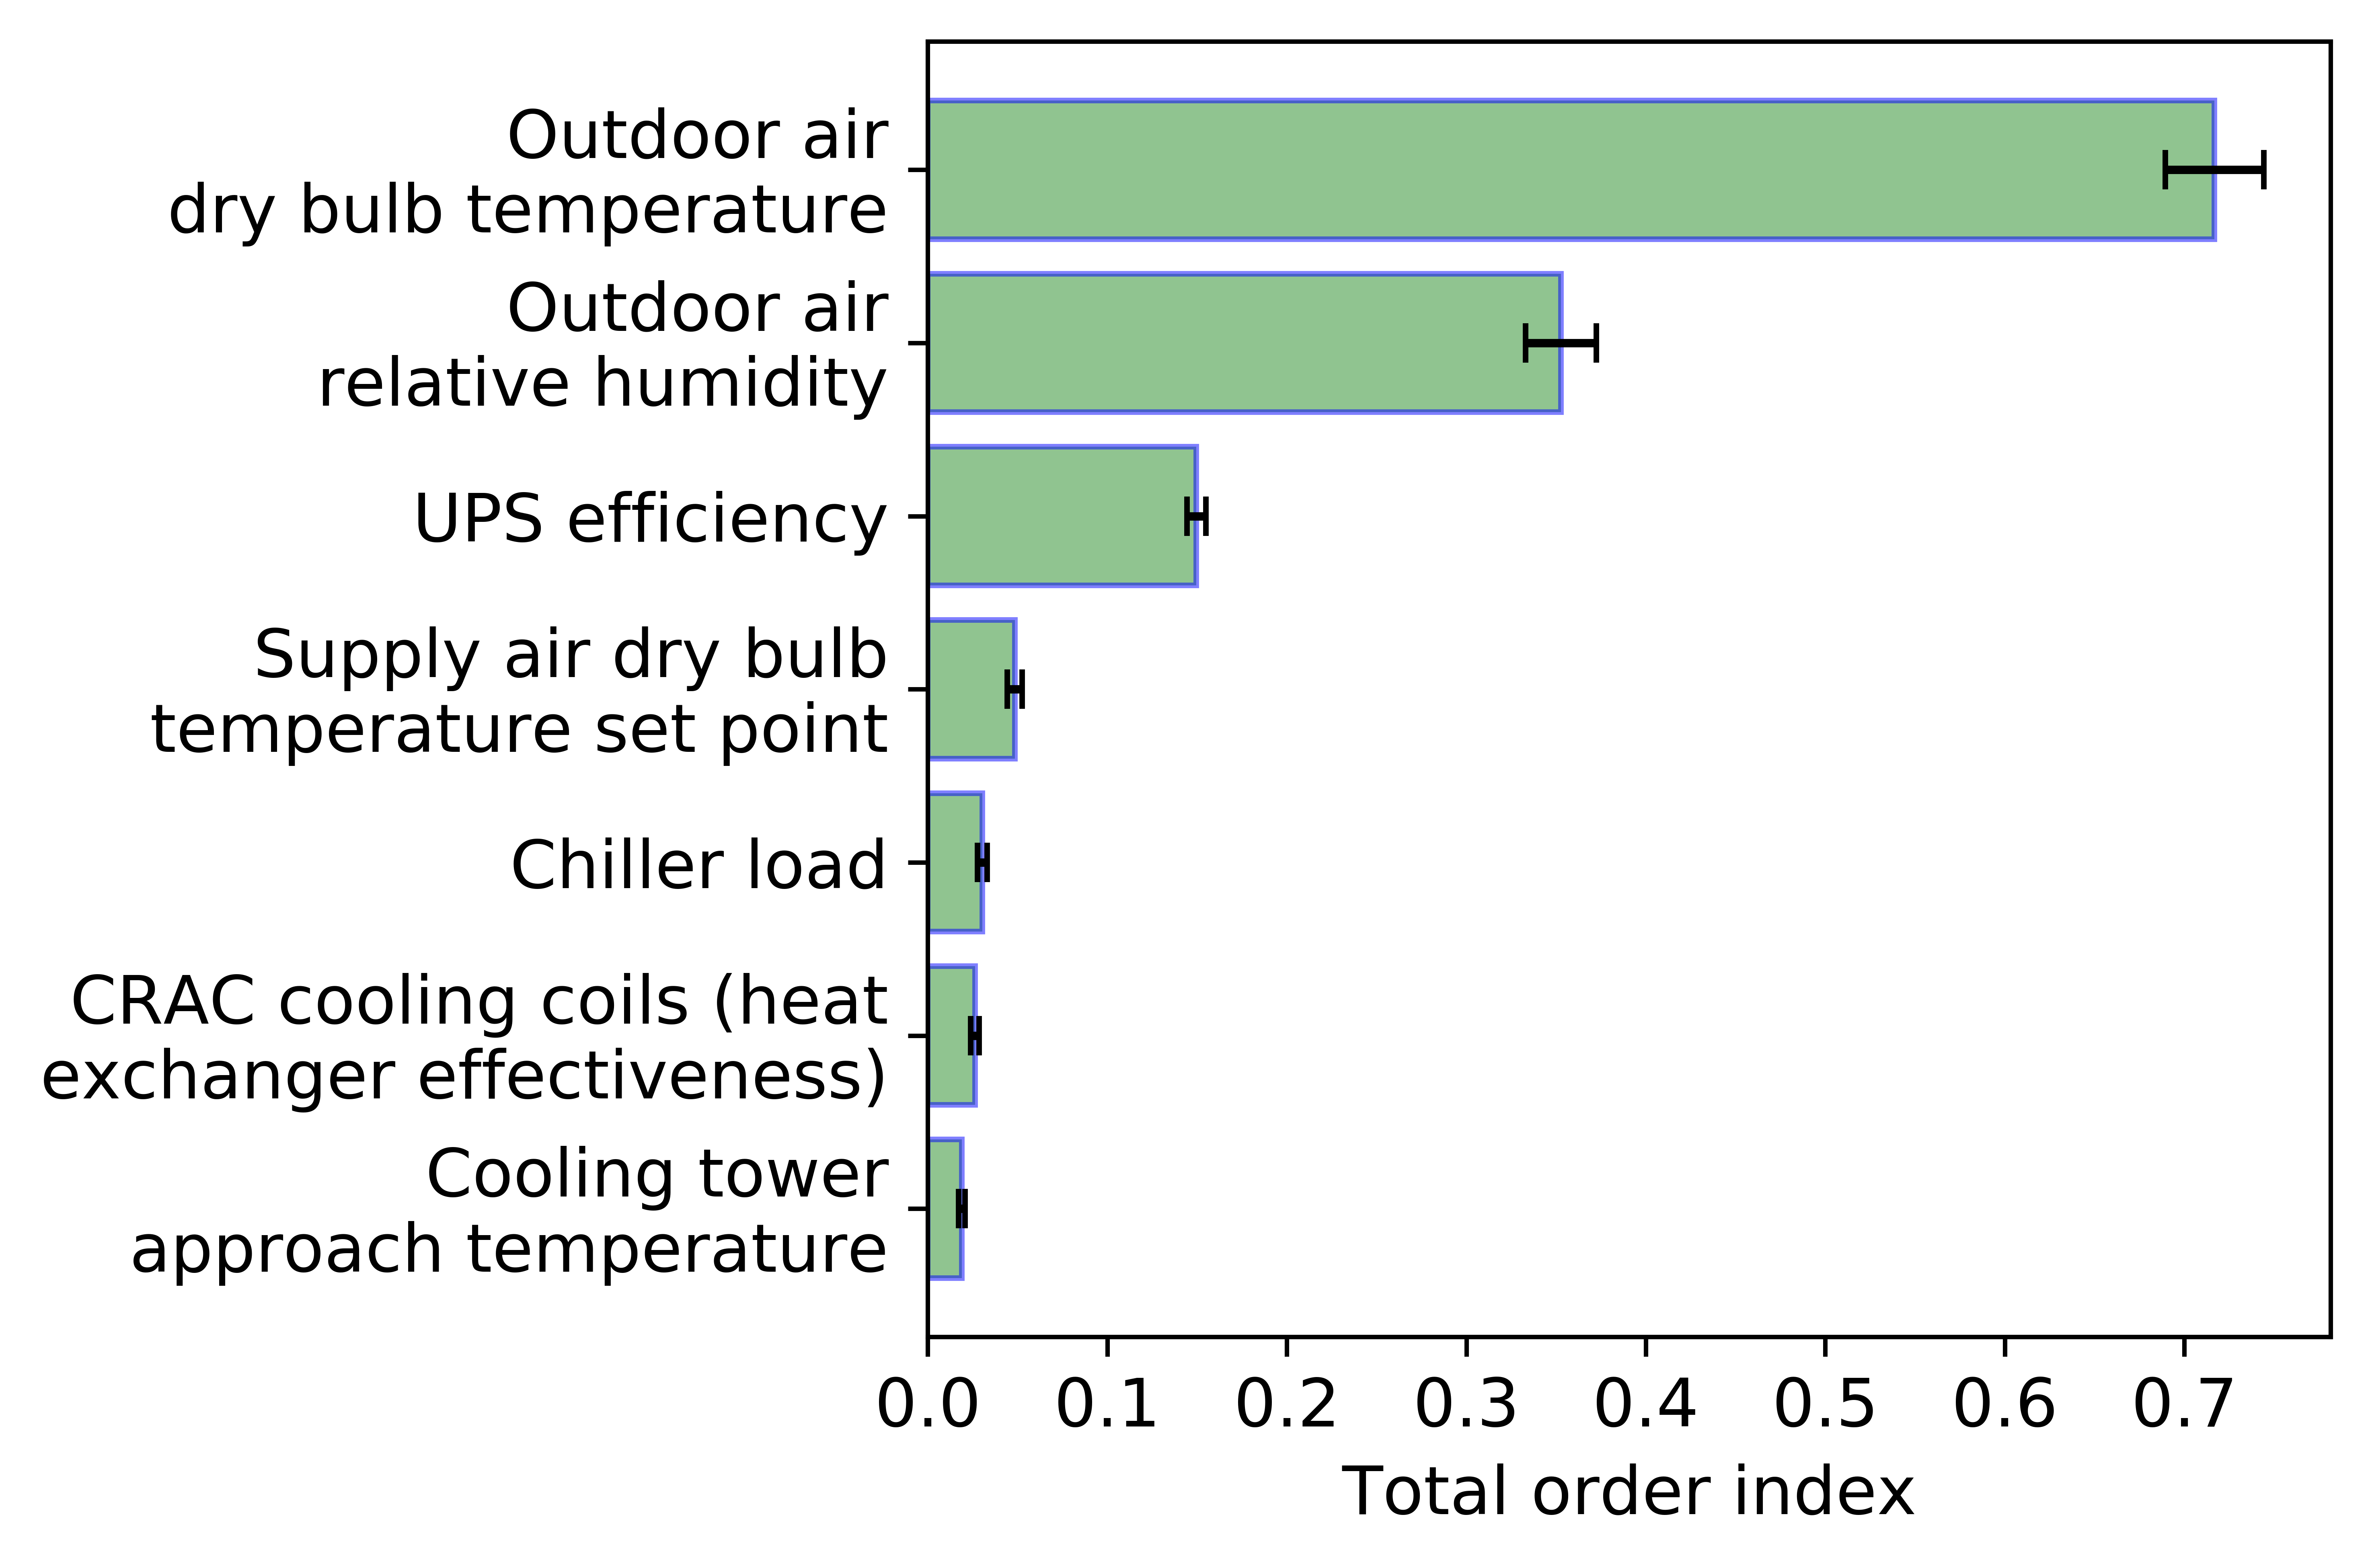

In [11]:
index=np.argsort(list)

plt.figure(dpi=1000)
plt.barh(range(len(list)), list[index], xerr=list_cf[index], align='center',height=0.8,capsize=3.5,color='forestgreen',alpha=0.5,edgecolor='blue')
plt.xlabel("Total order index",fontsize=12)
plt.yticks(range(len(list)),label[::-1], ha='right',fontsize=12)
plt.xticks(fontsize=12)
plt.rc('font',family='Calibri')


plt.tight_layout()
#plt.savefig("WE_sensitity.svg", dpi=1000)
plt.show()

In [12]:
inx = np.argsort(Si['S1'])[::-1]
flabel_2 = []

for i in inx:
    flabel_2.append(problem_WE_Chiller['names'][i])
    
inx_1 = np.argsort(Si['ST'])[::-1]
flabel_1 = []

for i in inx_1:
    flabel_1.append(problem_WE_Chiller['names'][i])

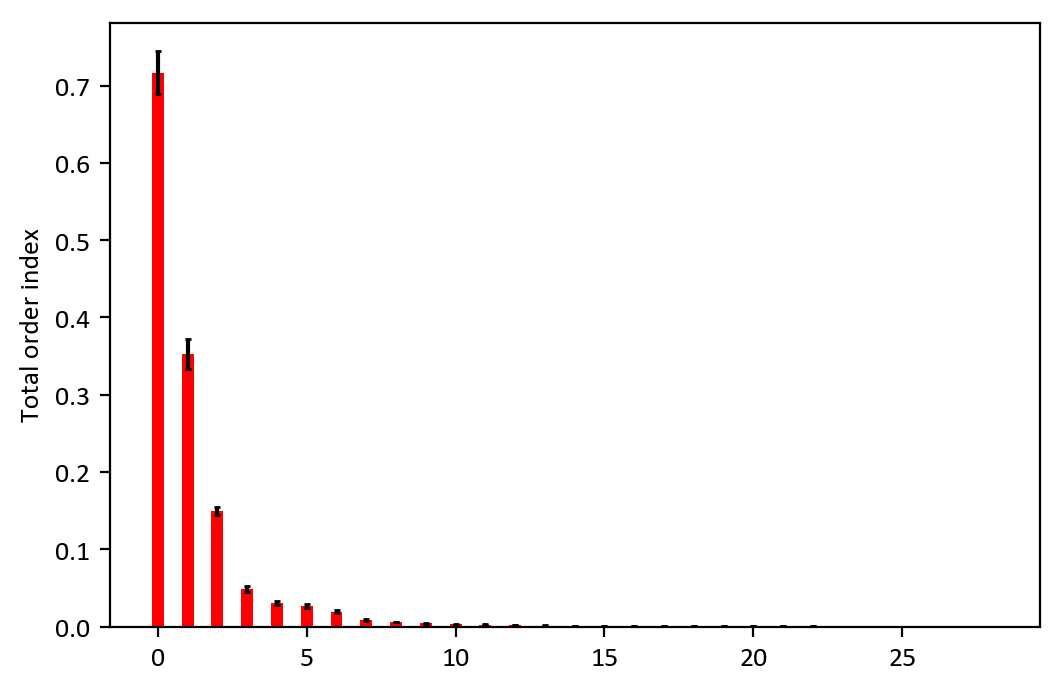

In [13]:
plt.figure(dpi=200)
list_2 = Si['S1'][inx]
list_cf_2 = Si['S1_conf'][inx]

list_1 = Si['ST'][inx_1]
list_cf_1 = Si['ST_conf'][inx_1]

plt.bar(range(len(list_1)),list_1,width=0.4,yerr=list_cf_1,align='center',capsize=1,color='r')

plt.ylabel("Total order index")

plt.show()

In [14]:
print(flabel_1)
print(list_1) 

['T_oa', 'RH_oa', 'UPS_e', 'T_sa_setpoint', 'Chiller_load', 'HTE', 'AT_CT', 'delta_T_water', 'PD_lr', 'pCOP', 'delta_T_air', 'Fan_Pressure_CRAC', 'Fan_e_CRAC', 'AT_HE', 'delta_T_CT', 'Fan_Pressure_CT', 'L_to_G', 'P_atm', 'Pump_Pressure_CT', 'Pump_e_CT', 'SHR', 'Fan_e_CT', 'Pump_Pressure_WE', 'L_percentage', 'Pump_e_WE', 'Pump_Pressure_CW', 'Pump_e_CW', 'Pump_e_HD', 'Pump_Pressure_HD']
[7.16833925e-01 3.52683481e-01 1.49692712e-01 4.84840215e-02
 3.04080455e-02 2.62876889e-02 1.89774110e-02 8.31729174e-03
 6.11648238e-03 4.20574894e-03 2.68361740e-03 2.59942204e-03
 1.72306527e-03 1.27463673e-03 1.26434668e-03 1.23466353e-03
 1.16638637e-03 9.50667811e-04 5.43843412e-04 2.84139920e-04
 2.21464083e-04 1.06894266e-04 9.48587970e-05 5.86566752e-05
 4.95184103e-05 1.66268787e-05 8.64085811e-06 2.23070200e-08
 1.08083515e-08]


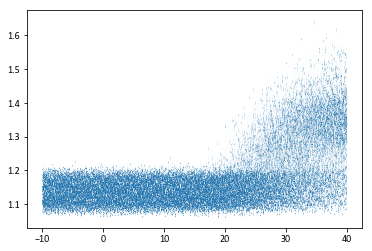

In [15]:
plt.scatter(sobol_values[:,0],Y_sobol,s=0.0001)